In [1]:
import pickle
import numpy as np

# Load data/qm9_test_nx.pkl
with open('data/qm9_test_nx.pkl', 'rb') as f:
    qm9_test_nx = pickle.load(f)
    
mol = qm9_test_nx[150]
print('Number of graphs in qm9_test_nx:', len(qm9_test_nx))



Number of graphs in qm9_test_nx: 13082


In [2]:
# print the node atttributes of the mol
print('Node attributes of the mol:')

# cuurently, we have 8 node attributes
print(mol.nodes(data=True))

Node attributes of the mol:
[(0, {'label': 'C', 'atomic_num': 6, 'formal_charge': 0, 'chiral_tag': rdkit.Chem.rdchem.ChiralType(0), 'hybridization': rdkit.Chem.rdchem.HybridizationType(4), 'num_explicit_hs': 0, 'is_aromatic': False}), (1, {'label': 'N', 'atomic_num': 7, 'formal_charge': 0, 'chiral_tag': rdkit.Chem.rdchem.ChiralType(0), 'hybridization': rdkit.Chem.rdchem.HybridizationType(4), 'num_explicit_hs': 0, 'is_aromatic': False}), (2, {'label': 'C', 'atomic_num': 6, 'formal_charge': 0, 'chiral_tag': rdkit.Chem.rdchem.ChiralType(0), 'hybridization': rdkit.Chem.rdchem.HybridizationType(4), 'num_explicit_hs': 0, 'is_aromatic': False}), (3, {'label': 'C', 'atomic_num': 6, 'formal_charge': 0, 'chiral_tag': rdkit.Chem.rdchem.ChiralType(0), 'hybridization': rdkit.Chem.rdchem.HybridizationType(3), 'num_explicit_hs': 0, 'is_aromatic': False}), (4, {'label': 'C', 'atomic_num': 6, 'formal_charge': 0, 'chiral_tag': rdkit.Chem.rdchem.ChiralType(0), 'hybridization': rdkit.Chem.rdchem.Hybridiza

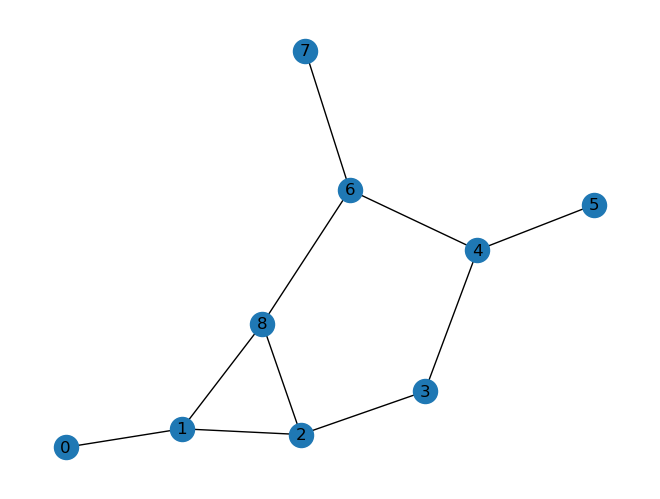

In [3]:
# visualize the graph of mol0
import networkx as nx
import matplotlib.pyplot as plt

# Draw the graph
nx.draw(mol, with_labels=True)
plt.show()

In [4]:
# extract rings from the graph
from utils.cell_lifting import *

mol_rings = get_rings(graph_to_edge_index(mol))
print('Rings of the mol:') 
print(mol_rings)

Rings of the mol:
[(2, 3, 4, 6, 8), (1, 2, 8)]


## Geting Rank-2 cells (rings) for molecules 

In [5]:
with open('data/qm9_train_nx.pkl', 'rb') as f:
    qm9_train = pickle.load(f)
    
with open('data/qm9_test_nx.pkl', 'rb') as f:
    qm9_test = pickle.load(f)

mol_train_rings = []
mol_test_rings = []

# iterate qm9
for graph in qm9_train:
    edge_index = graph_to_edge_index(graph)
    if edge_index.nelement() == 0:
        mol_test_rings.append([])
        continue
    rings = get_rings(edge_index)
    mol_train_rings.append(rings)

# store in pickle
with open('data/qm9_test_rings.pkl', 'wb') as f:
    pickle.dump(mol_test_rings, f)

mol_train_rings = []
for graph in qm9_train:
    edge_index = graph_to_edge_index(graph)
    if edge_index.nelement() == 0:
        mol_train_rings.append([])
        continue
    rings = get_rings(edge_index)
    mol_train_rings.append(rings)

# store in pickle
with open('data/qm9_train_rings.pkl', 'wb') as f:
    pickle.dump(mol_train_rings, f)